# **07 EDA and Hypotheses tests**

## Objectives

* Continue EDA to support Hypotheses tests 

## Inputs

* housing_cleaned.csv

## Outputs

* housing_cleaned_for_model.csv

---

# EDA

Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

In [2]:
# read the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned.csv')

Hypothesis 1: The property type has an effect on the price per square metre: Detached houses have a higher price per square metre than semi-detached, which are higher than terraced, which are higher than flats. This will be validated using visualizations and statistical (ANOVA and Tukey) tests.


In [3]:
# what are the prices by property_type? Output the descriptive statistics to 0 decimal places and separate thousands with commas
# order the columns in the table by mean price
df.groupby('property_type')['price'].describe().apply(lambda x: x.astype(int)).T.style.format("{:,.0f}").set_caption("Descriptive Statistics of Prices by Property Type")

property_type,D,F,S,T
count,"2,020",579,"2,819","1,830"
mean,"412,192","166,347","259,716","218,775"
std,"147,956","70,730","90,069","82,111"
min,"79,000","77,000","77,000","75,500"
25%,"307,500","118,500","200,000","167,500"
50%,"381,625","148,000","247,500","205,000"
75%,"485,000","193,750","297,872","252,500"
max,"948,500","550,000","844,000","940,000"


Note there is an order to the price by property_type with flats being the cheapest and detached houses the most expensive

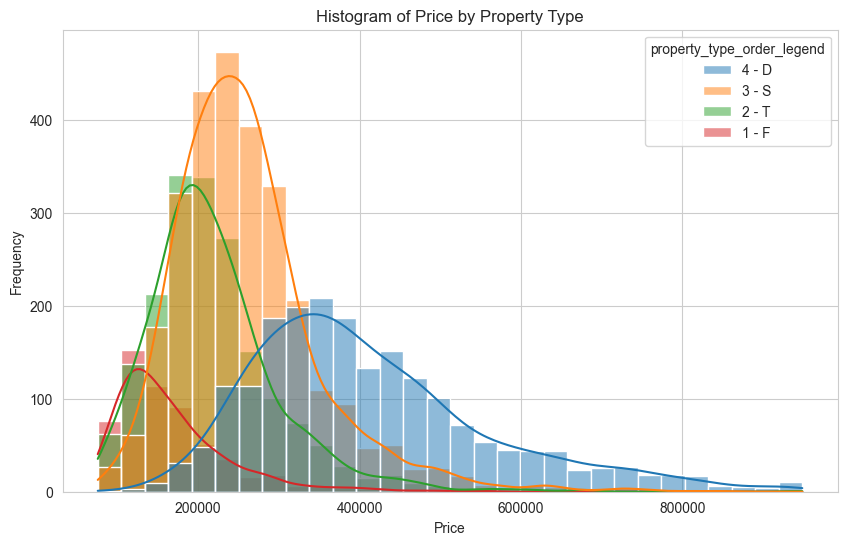

In [4]:
# create a new column for order of property types by from 1 for Flats to 4 for Detached houses
property_type_order = {
    'F': 1,
    'T': 2,
    'S': 3,
    'D': 4
}
df['property_type_order'] = df['property_type'].map(property_type_order)

# plot histogram of price distribution of property_type

# set the legend labels to the property_type concatenated with the property_type_order
df['property_type_order_legend'] = df['property_type_order'].astype(str) + ' - ' + df['property_type']

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', hue='property_type_order_legend', bins=30, alpha=0.5, kde=True)
plt.title('Histogram of Price by Property Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# drop intermediate columns used for plotting
df = df.drop(columns=['property_type_order_legend'])

The general order of the prices by property type can be seen clearly in this histogram.

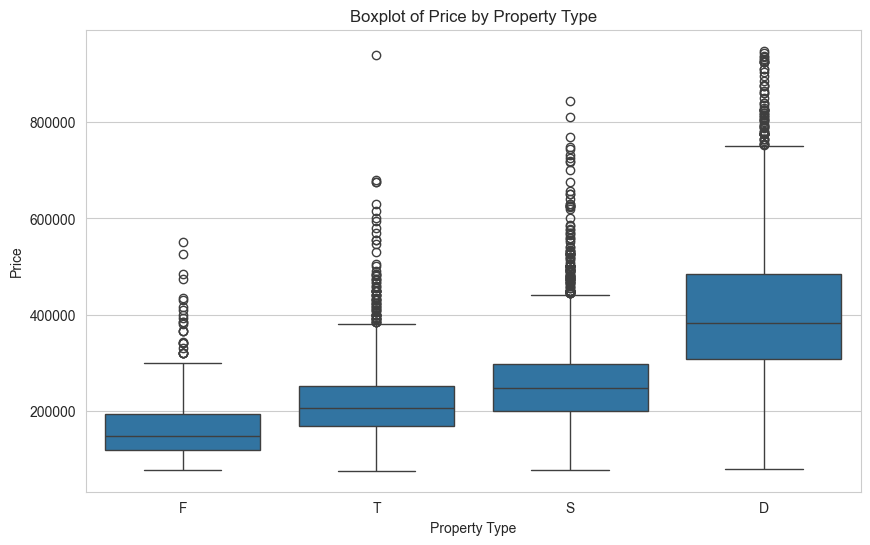

In [6]:
# plot boxplot of price by property_type sorted by property_type_order
mean_prices = df.groupby('property_type')['price'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='property_type', y='price', order=mean_prices.index)
plt.title('Boxplot of Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.show()

In [ ]:
# Hypothesis 1 Test: Is the difference in price by property type statistically significant?
# Null hypothesis: There is no difference in prices between property types
# Alternative hypothesis: There is a difference in prices between property types

import scipy.stats as stats
# ANOVA test
f_val, p_val = stats.f_oneway(
    df[df['property_type'] == 'F']['price'],
    df[df['property_type'] == 'T']['price'],
    df[df['property_type'] == 'S']['price'],
    df[df['property_type'] == 'D']['price']
)
print(f"ANOVA test: F-value = {f_val}, p-value = {p_val:.4f}")

ANOVA test: F-value = 1486.5637326865171, p-value = 0.0000


---

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in prices between at least two property types.

In [ ]:
# As we have multiple property types, we can use Tukey's HSD to find out which property types are different
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['price'], groups=df['property_type'], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     D      F -245845.0487   0.0 -258754.9343 -232935.1631   True
     D      S  -152475.847   0.0 -160459.2639 -144492.4301   True
     D      T -193417.0424   0.0 -202255.2329  -184578.852   True
     F      S   93369.2017   0.0   80873.5449  105864.8585   True
     F      T   52428.0063   0.0   39369.6716   65486.3409   True
     S      T  -40941.1954   0.0  -49162.5033  -32719.8876   True
-----------------------------------------------------------------


All pairwise comparisons are significant i.e. All property types have significantly different prices from each other
We therefore reject the null hypothesis for all group comparisons and conclude that there is a statistically significant difference between all property types.

In [ ]:
# visualize the relationship using an interactive scatter plot in plotly 
import plotly.express as px
fig = px.scatter(df, x='total_floor_area', y='price', color='property_type', hover_data=['price', 'total_floor_area', 'property_type'])
fig.show()


In [ ]:
# what is the correlation between total_floor_area and price?
corr = df['total_floor_area'].corr(df['price'])
R2 = corr**2
print(f"Correlation between total floor area and price: {corr}")
# R squared value
print(f"R squared value: {R2}")
# how much of the variance in price is explained by total floor area?
print(f"Variance in price explained by total floor area: {R2 * 100:.1f}%")


Correlation between total floor area and price: 0.7337063171844024
R squared value: 0.5383249598762989
Variance in price explained by total floor area: 53.8%


Hypothesis 2: New builds sell at a premium compared to older properties. This will be validated using visualizations and statistical tests (t-test).
- Null hypothesis: There is no difference in prices between new builds and older properties
- Alternative hypothesis: There is a difference in prices between new builds and older properties


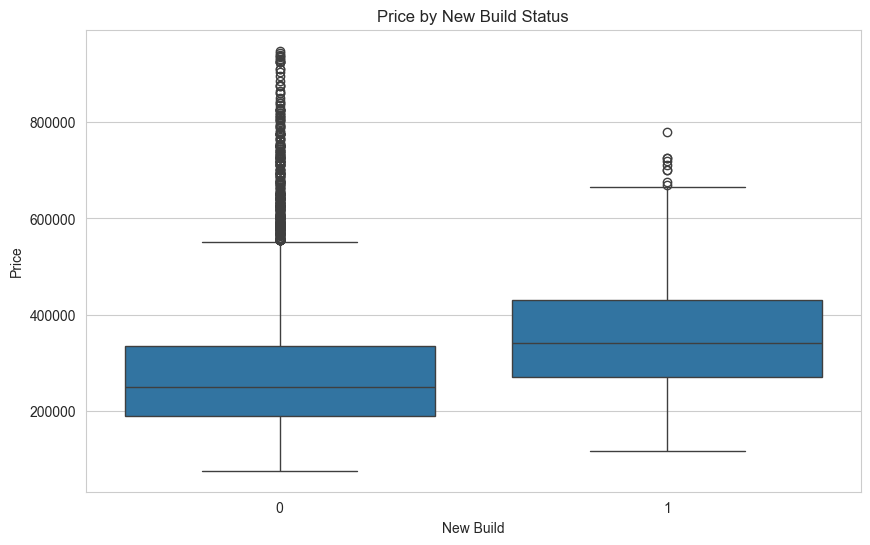

In [ ]:
# boxplot of price by new_build
plt.figure(figsize=(10, 6))
sns.boxplot(x='new_build', y='price', data=df)
plt.title('Price by New Build Status')
plt.xlabel('New Build')
plt.ylabel('Price')
plt.show()


In [ ]:
# Is the difference in price by new_build statistically significant?
# t-test
new_build_prices = df[df['new_build'] == 1]['price']
old_build_prices = df[df['new_build'] == 0]['price']
t_stat, p_value = stats.ttest_ind(new_build_prices, old_build_prices)
# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in prices.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in prices.")

print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")

Reject the null hypothesis: There is a significant difference in prices.
T-test: t-statistic = 11.15, p-value = 0.00


In [ ]:
# what is the effect size (Cohen's d) of the difference in prices between new builds and older properties?
# Used Copilot to generate this function
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    d = (np.mean(x) - np.mean(y)) / pooled_std
    return d
d = cohen_d(new_build_prices, old_build_prices)
print(f"Cohen's d: {d:.2f}")
# interpretation of Cohen's d
if abs(d) < 0.2:
    interpretation = "negligible"
elif abs(d) < 0.5:
    interpretation = "small"
elif abs(d) < 0.8:
    interpretation = "medium"
else:
    interpretation = "large"
print(f"Effect size (Cohen's d) interpretation: {d:.1f} standard deviations,  {interpretation} effect")

# what is the premium for new builds all else being equal?
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit a linear regression model
model = ols('price ~ new_build', data=df).fit()
# Get the estimated coefficient for the new_build variable
new_build_premium = model.params['new_build']
print(f"New build premium: {new_build_premium:.2f}")


Cohen's d: 0.60
Effect size (Cohen's d) interpretation: 0.6 standard deviations,  medium effect
New build premium: 80826.63


Hypothesis 3: A higher Index of Multiple Deprivation (IMD) decile is associated with a higher price per square metre. The expected relationship is a positive correlation. This will be validated using visualizations, statistical tests (Spearman’s rho) or regression analysis.
- Null hypothesis: There is no correlation between IMD decile and price per square metre
- Alternative hypothesis: There is a correlation between IMD decile and price per square metre


In [ ]:
df['price_per_sqm'] = df['price'] / df['total_floor_area']
df.head()

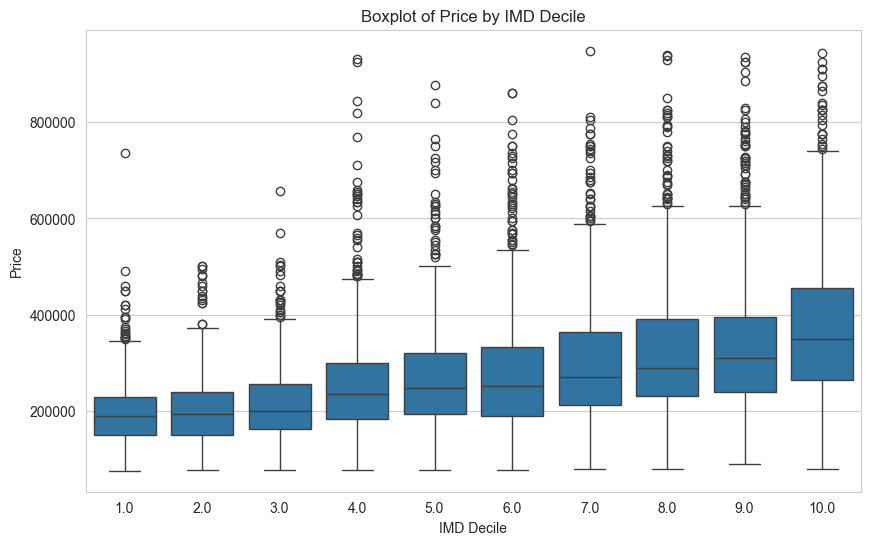

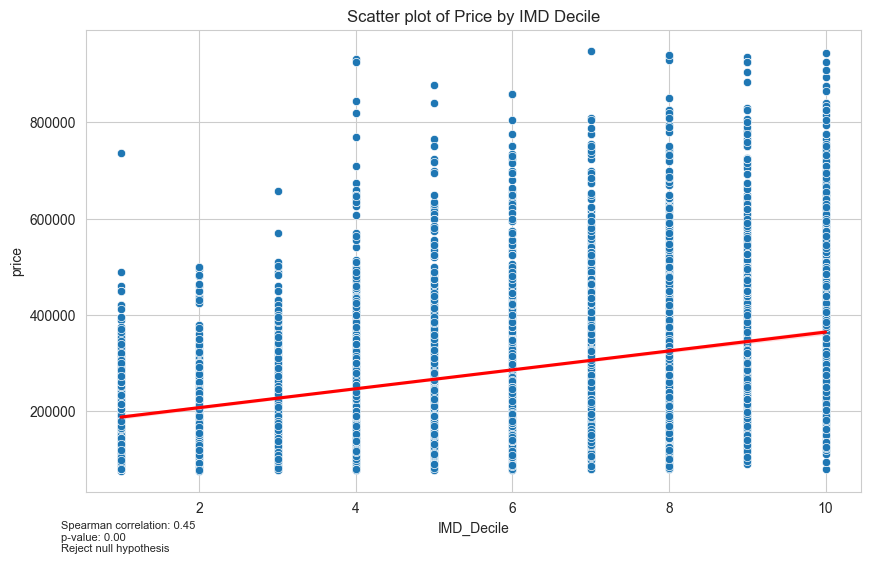

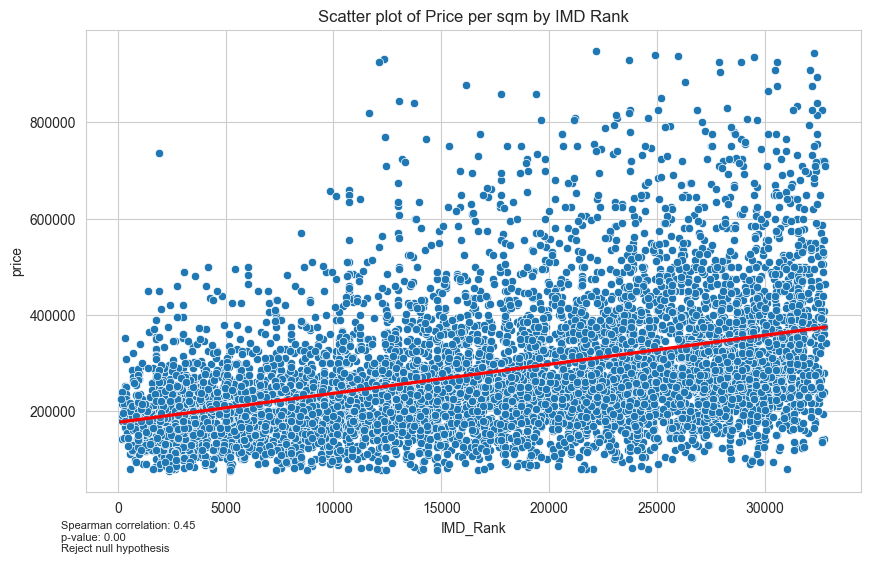

In [ ]:
# Hypothesis 3: A higher Index of Multiple Deprivation (IMD) decile is associated with a higher price. The expected relationship is a positive correlation. This will be validated using visualizations, statistical tests (Spearman’s rho) or regression analysis.
# Null hypothesis: There is no correlation between IMD decile and price
# Alternative hypothesis: There is a correlation between IMD decile and price

# boxplot of price per sqm by IMD Decile
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='IMD_Decile', y='price')
plt.title('Boxplot of Price by IMD Decile')
plt.xlabel('IMD Decile')
plt.ylabel('Price')
plt.show()

# scatter plot of price by IMD Decile
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='IMD_Decile', y='price')
plt.title('Scatter plot of Price by IMD Decile')
plt.xlabel('IMD Decile')
plt.ylabel('Price')
# include a linear regression line
sns.regplot(data=df, x='IMD_Decile', y='price', scatter=False, color='red')
corr, p_value = stats.spearmanr(df['IMD_Decile'], df['price'])
# Add a footnote with the hypothesis conclusion - supported by Copilot
alpha = 0.05
if p_value < alpha:
    plt.figtext(0.1, 0.01, f'Spearman correlation: {corr:.2f}\np-value: {p_value:.2f}\nReject null hypothesis', fontsize=8)
else:
    plt.figtext(0.1, 0.01, f'Spearman correlation: {corr:.2f}\np-value: {p_value:.2f}\nFail to reject null hypothesis', fontsize=8)
plt.show()

# scatter plot of price by IMD Rank
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='IMD_Rank', y='price')
plt.title('Scatter plot of Price per sqm by IMD Rank')
plt.xlabel('IMD Rank')
plt.ylabel('Price')
# include a linear regression line
sns.regplot(data=df, x='IMD_Rank', y='price', scatter=False, color='red')
corr, p_value = stats.spearmanr(df['IMD_Rank'], df['price'])
# Add a footnote with the hypothesis conclusion - supported by Copilot
alpha = 0.05
if p_value < alpha:
    plt.figtext(0.1, 0.01, f'Spearman correlation: {corr:.2f}\np-value: {p_value:.2f}\nReject null hypothesis', fontsize=8)
else:
    plt.figtext(0.1, 0.01, f'Spearman correlation: {corr:.2f}\np-value: {p_value:.2f}\nFail to reject null hypothesis', fontsize=8)
plt.show()



Hypothesis 4: Properties with EPC bands A to C have a price premium compared to bands D to G. The expected relationship is a positive effect. This will be validated using visualizations, ANOVA or regression.
- Null hypothesis: There is no difference in prices between EPC bands A to C and D to G
- Alternative hypothesis: There is a difference in prices between EPC bands A to C and D to G

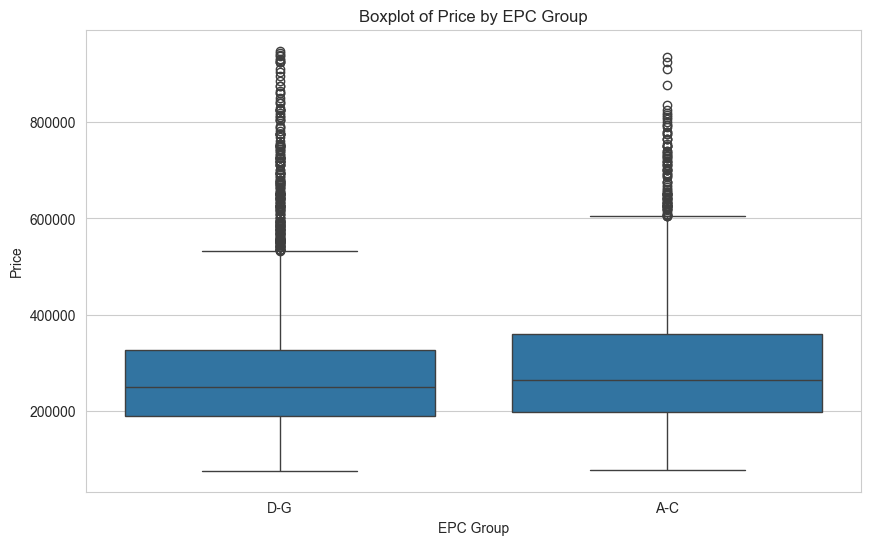

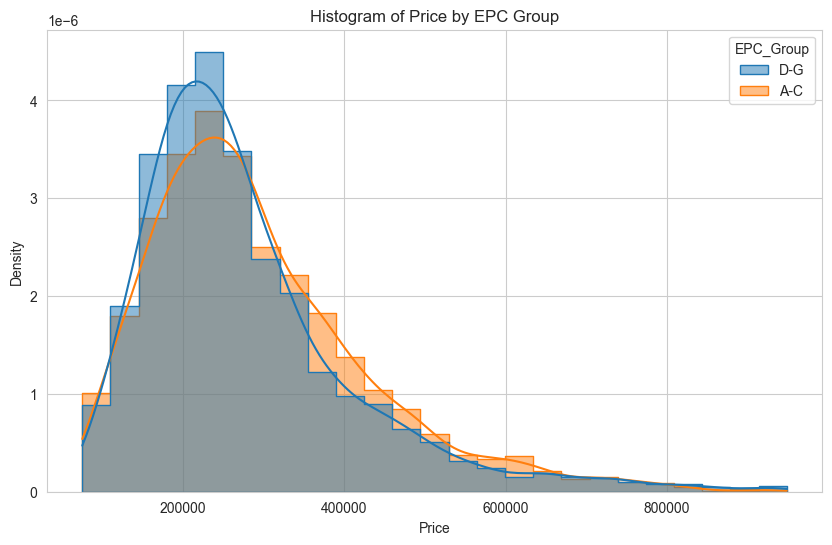

In [ ]:
# Hypothesis 4: Properties with EPC bands A to C have a price premium compared to bands D to G. The expected relationship is a positive effect. This will be validated using visualizations, ANOVA or regression.
# Null hypothesis: There is no difference in prices between EPC bands A to C and D to G
# Alternative hypothesis: There is a difference in prices between EPC bands A to C and D to G

# split energy_band_num into two groups 7-5 (A-C) and 4-1 (D-G)
df['EPC_Group'] = np.where(df['energy_band_num'].isin([7, 6, 5]), 'A-C', 'D-G')
# boxplot of price by EPC_Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='EPC_Group', y='price')
plt.title('Boxplot of Price by EPC Group')
plt.xlabel('EPC Group')
plt.ylabel('Price')
plt.show()

# histogram of price by EPC_Group
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', hue='EPC_Group', element='step', stat='density', common_norm=False, bins=25, alpha=0.5, kde=True)
plt.title('Histogram of Price by EPC Group')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()


In [ ]:
# test the hypothesis that there is a difference in prices between EPC bands A to C and D to G
import scipy.stats as stats
# use a t-test
t_stat, p_value = stats.ttest_ind(df[df['EPC_Group'] == 'A-C']['price'],
                                  df[df['EPC_Group'] == 'D-G']['price'])
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")
# interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in prices between EPC bands A-C and D-G.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in prices between EPC bands A-C and D-G.")
    

T-test: t-statistic = 4.28, p-value = 0.00
Reject the null hypothesis: There is a significant difference in prices between EPC bands A-C and D-G.


Hypothesis 5: Leasehold properties sell at a discount compared to freehold properties. The expected relationship is a negative effect. This will be validated using visualizations, a t-test and regression analysis.
- Null hypothesis: There is no difference in prices between leasehold and freehold properties
- Alternative hypothesis: There is a difference in prices between leasehold and freehold properties


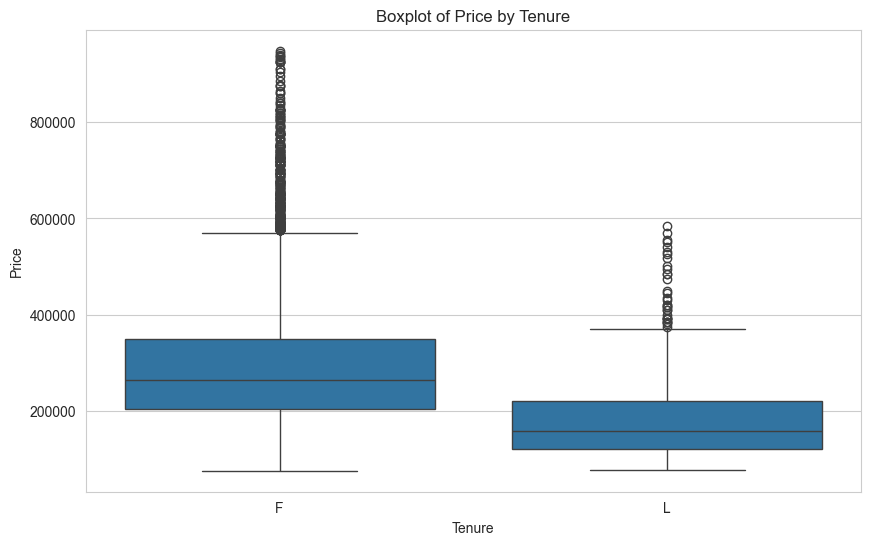

In [ ]:
# Hypothesis 5: Leasehold properties sell at a discount compared to freehold properties. The expected relationship is a negative effect. This will be validated using visualizations, a t-test and regression analysis.
# Null hypothesis: There is no difference in prices between leasehold and freehold properties
# Alternative hypothesis: There is a difference in prices between leasehold and freehold properties
# boxplot of price by tenure
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='tenure', y='price')
plt.title('Boxplot of Price by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Price')
plt.show()

---

In [ ]:
# t-test
t_stat, p_value = stats.ttest_ind(df[df['tenure'] == 'L']['price'],
                                  df[df['tenure'] == 'F']['price'])
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")
# interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in prices between leasehold and freehold properties.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in prices between leasehold and freehold properties.")


T-test: t-statistic = -22.24, p-value = 0.00
Reject the null hypothesis: There is a significant difference in prices between leasehold and freehold properties.
